# 데이터 수집 및 불러오기

- bert_avengers_crawling.ipynb 참고


In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, Dropout,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [86]:
train = pd.read_csv('train.csv',names = ['label', 'document'])
worst_train = pd.read_csv('worst_train.csv',names = ['label', 'document'])
    
class data():        
    def best_data(self):
        # 5만개 수집만개 수집 (별점 7점이상)
        best_train = train[train.label==1]
        best_train = best_train.dropna()
        best_df = best_train[:3998] #수집한 부정 데이터와 개수 동일 유지
        return best_df

    def worst_data(self):
        worst_df = worst_train.dropna()
        return worst_df

    def train_test_merge(self,best_df1, worst_df1):
        train = pd.concat([best_df1, worst_df1])
        train.reset_index(drop=True, inplace=True)
        print("데이터의 shape : ", train.shape)
        print("데이터의 긍정 부정 비율 : \n", train['label'].value_counts())
        return train

data = data()
best_df = data.best_data()
worst_df = data.worst_data()
train = data.train_test_merge(best_df, worst_df)
train

데이터의 shape :  (7996, 2)
데이터의 긍정 부정 비율 : 
 1    3998
0    3998
Name: label, dtype: int64


,label,document
0,1,스포일러가 포함된 감상평입니다. 감상평 보기아이언맨으로 시작해서 아이언맨으로 끝나는...
1,1,첨볼땐 와~하고봤는데 두번볼때 울었네ㅜㅜ
2,1,마블펜이라면 무조건 봐야하는 영화... 진짜 처음에 아이언맨1편 나오고 토르1편나올...
3,1,토니스타크 정말 감동이었고 뭔가 세드렌딩이면서 모두를 구한 해피엔딩이라 재미있게 봤...
4,1,스포일러가 포함된 감상평입니다. 감상평 보기지금은 늣었지만 아이언맨 존경합니다
...,...,...
7991,0,관람객그냥 괜찮네용괜찮아ㅇㅇ
7992,0,관람객2시간 넘는 시간동안 영화가좀 지루해서 몸을 배배꼬꼬 여러차레자세를 바꾸고 하...
7993,0,관람객마블팬도 뭣도 아닌 입장에서 순수하게 봤을때 스토리 진행도 진부하고 액션이나 ...
7994,0,"볼만한데 전 작품들보다 연출, 편집, 오락성등등 모든게 부족했던것같아요~ 너무 기대..."


# 데이터 전처리

#### 스포일러 포함 감상평 문구 제거

#### 형태소 분석기 1 : okt 라이브러리 사용
- norm옵션 : 정규화 안녕하세욬ㅋㅋ=> 안녕하세요
- stem옵션 : 원형을 찾아주는 옵션 (그래요 -> 그렇다)


- **은,는,이,가 조사 위주의 불용어 제거**
- 영화리뷰에 영향많이 미치지 않을 것

#### 형태소 분석기 2: mecab 라이브러리 사용

In [87]:
okt = Okt()
mecab = Mecab(dicpath=r"C:\mecab\mecab-ko-dic")


class preprocessing():
    def __init__(self):
            # 스포일러 포함 감상평 문구 제거
        def reduce_spoil(self):
            train.document = train.document.apply(lambda x:x.replace('스포일러가 포함된 감상평입니다. 감상평 보기',''))
            return train
        self.train = reduce_spoil(train)
        self.train2 = reduce_spoil(train)
    
    def analysis(self):
        def tokenize1(doc):
            # norm은 정규화, stem은 근어로 표시하기를 나타냄
            return ['/'.join(t) for t in okt.pos(doc, norm=True, stem=True)] 
        def tokenize2(doc):
            # 조사 관련 형태소는 없애주기 위함
            word = ['/'.join(t) for t in okt.pos(doc, norm=True, stem=True) if 'Josa' not in t]
            return word
        train['token_okt1'] = train['document'].apply(tokenize1)
        train['token_okt2'] = train['document'].apply(tokenize2)

        # 조사 및 괄호를 불용어로 정의
        stopwords = ['(',')','도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '음', '면']
        train['token_mecab1'] = train['document'].apply(mecab.morphs)
        train['token_mecab2'] = train['token_mecab1'].apply(lambda x: [item for item in x if item not in stopwords])
        return train
    
preprocess = preprocessing()
train = preprocess.analysis()
train

,label,document,token_okt1,token_okt2,token_mecab1,token_mecab2
0,1,아이언맨으로 시작해서 아이언맨으로 끝나는 엄청난 시나리오다배우들의 연기도 엄청났다또...,"[아이언맨/Noun, 으로/Josa, 시작/Noun, 하다/Verb, 아이언맨/No...","[아이언맨/Noun, 시작/Noun, 하다/Verb, 아이언맨/Noun, 끝나다/V...","[아이언맨, 으로, 시작, 해서, 아이언맨, 으로, 끝, 나, 는, 엄청난, 시나리...","[아이언맨, 으로, 시작, 해서, 아이언맨, 으로, 끝, 나, 엄청난, 시나리오, ..."
1,1,첨볼땐 와~하고봤는데 두번볼때 울었네ㅜㅜ,"[첨/Adverb, 볼땐/Noun, 오다/Verb, ~/Punctuation, 하다...","[첨/Adverb, 볼땐/Noun, 오다/Verb, ~/Punctuation, 하다...","[첨, 볼땐, 와, ~, 하, 고, 봤, 는데, 두, 번, 볼, 때, 울, 었, 네...","[첨, 볼땐, ~, 봤, 는데, 두, 번, 볼, 때, 울, 었, ㅜㅜ]"
2,1,마블펜이라면 무조건 봐야하는 영화... 진짜 처음에 아이언맨1편 나오고 토르1편나올...,"[마블/Noun, 펜/Noun, 이/Determiner, 라면/Noun, 무조건/N...","[마블/Noun, 펜/Noun, 이/Determiner, 라면/Noun, 무조건/N...","[마블, 펜, 이, 라면, 무조건, 봐야, 하, 는, 영화, ., .., 진짜, 처...","[마블, 펜, 라면, 무조건, 봐야, 영화, ., .., 진짜, 처음, 아이언맨, ..."
3,1,토니스타크 정말 감동이었고 뭔가 세드렌딩이면서 모두를 구한 해피엔딩이라 재미있게 봤...,"[토니스타크/Noun, 정말/Noun, 감동/Noun, 이다/Verb, 뭔가/Nou...","[토니스타크/Noun, 정말/Noun, 감동/Noun, 이다/Verb, 뭔가/Nou...","[토니, 스타크, 정말, 감동, 이, 었, 고, 뭔가, 세드, 렌, 딩, 이, 면서...","[토니, 스타크, 정말, 감동, 었, 뭔가, 세드, 렌, 딩, 면서, 모두, 구한,..."
4,1,지금은 늣었지만 아이언맨 존경합니다,"[지금/Noun, 은/Josa, 늣었/Noun, 지만/Josa, 아이언맨/Noun,...","[지금/Noun, 늣었/Noun, 아이언맨/Noun, 존경/Noun, 하다/Verb]","[지금, 은, 늣, 었, 지만, 아이언맨, 존경, 합니다]","[지금, 늣, 었, 지만, 아이언맨, 존경, 합니다]"
...,...,...,...,...,...,...
7991,0,관람객그냥 괜찮네용괜찮아ㅇㅇ,"[관람객/Noun, 그냥/Noun, 괜찮다/Adjective, 네/Determine...","[관람객/Noun, 그냥/Noun, 괜찮다/Adjective, 네/Determine...","[관람객, 그냥, 괜찮, 네, 용, 괜찮, 아, ㅇㅇ]","[관람객, 그냥, 괜찮, 용, 괜찮, 아, ㅇㅇ]"
7992,0,관람객2시간 넘는 시간동안 영화가좀 지루해서 몸을 배배꼬꼬 여러차레자세를 바꾸고 하...,"[관람객/Noun, 2시간/Number, 넘다/Verb, 시간/Noun, 동안/No...","[관람객/Noun, 2시간/Number, 넘다/Verb, 시간/Noun, 동안/No...","[관람객, 2, 시간, 넘, 는, 시간, 동안, 영화, 가, 좀, 지루, 해서, 몸...","[관람객, 2, 시간, 넘, 시간, 동안, 영화, 좀, 지루, 해서, 몸, 배배, ..."
7993,0,관람객마블팬도 뭣도 아닌 입장에서 순수하게 봤을때 스토리 진행도 진부하고 액션이나 ...,"[관람객/Noun, 마블/Noun, 팬/Noun, 도/Josa, 뭣/Noun, 도/...","[관람객/Noun, 마블/Noun, 팬/Noun, 뭣/Noun, 아니다/Adject...","[관람객, 마블, 팬, 도, 뭣, 도, 아닌, 입장, 에서, 순수, 하, 게, 봤,...","[관람객, 마블, 팬, 뭣, 아닌, 입장, 에서, 순수, 봤, 때, 스토리, 진행,..."
7994,0,"볼만한데 전 작품들보다 연출, 편집, 오락성등등 모든게 부족했던것같아요~ 너무 기대...","[볼/Noun, 만/Josa, 한/Determiner, 데/Noun, 전/Noun,...","[볼/Noun, 한/Determiner, 데/Noun, 전/Noun, 작품/Noun...","[볼, 만, 한데, 전, 작품, 들, 보다, 연출, ,, 편집, ,, 오락, 성, ...","[볼, 한데, 전, 작품, 보다, 연출, ,, 편집, ,, 오락, 성, 등등, 모든..."


In [88]:
 def train_test(self):
        train_data, test_data =  train_test_split(train, train['label'], test_size = 0.25, random_state = 42)
        print('훈련용 리뷰의 개수 :', len(train_data))
        print('테스트용 리뷰의 개수 :', len(test_data))
        return train_data, test_data
    
train_data, test_data = train_test_split(train)

# 정수 인코딩

- dictonary, nltk 패키지를 이용할 수도 있지만, keras에서 텍스트 처리에 자동으로 단어 빈도가 높은 단어의 인덱스는 낮게끔 설정해준다!!

X_train, y_Train, X_test, y_test (5997,) (5997,) (1999,) (1999,)

단어 집합(vocabulary)의 크기 : 6854
등장 빈도가 1번 이하인 희귀 단어의 수: 3205
단어 집합에서 희귀 단어의 비율: 46.76101546542165
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.89485708730313

vocab size : 3651

리뷰의 최대 길이 : 64
리뷰의 평균 길이 : 13.721527430381858


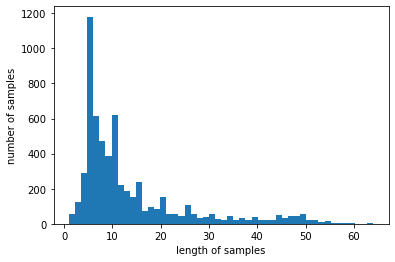

In [89]:
# 토큰 방법을 입력, 단어 빈도 수
def convert_input(token_analysis,how_many):
    X_train = train_data[token_analysis].values
    y_train = train_data['label']
    X_test= test_data[token_analysis].values
    y_test = test_data['label']
    print('X_train, y_Train, X_test, y_test', X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    
     # 정수인코딩
    tokenizer = Tokenizer( oov_token="<OOV>")
    tokenizer.fit_on_texts(X_train)
    
    threshold = how_many
    total_cnt = len(tokenizer.word_index) # 단어의 수
    rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
    total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
    rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in tokenizer.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value

    print('\n단어 집합(vocabulary)의 크기 :',total_cnt)
    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)
   

    # 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
    # 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
    vocab_size = total_cnt - rare_cnt + 2
    print('\nvocab size :',vocab_size)
    
    tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
    tokenizer.fit_on_texts(X_train)
    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)
    
    print('\n리뷰의 최대 길이 :',max(len(l) for l in X_train))
    print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
    plt.hist([len(s) for s in X_train], bins=50)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.show()

    return X_train, y_train, X_test, y_test, vocab_size

X_train, y_train, X_test, y_test, vocab_size = convert_input('token_okt1',2)

# 패딩

In [90]:
def padding_len(max_len, sentences):
    cnt = 0
    for s in sentences:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(sentences))*100))
    return max_len
padding_len(55, X_train)
padding_len(55, X_test)

전체 샘플 중 길이가 55 이하인 샘플의 비율: 99.74987493746873
전체 샘플 중 길이가 55 이하인 샘플의 비율: 99.79989994997499


55

In [91]:
def padding(max_len):
    x_train = pad_sequences(X_train, maxlen = max_len)
    x_test = pad_sequences(X_test, maxlen = max_len)
    print(x_train.shape, x_test.shape)
    return x_train, x_test, max_len

X_train, X_test, max_len = padding(55)

(5997, 55) (1999, 55)


# 모델링

1. DNN 구조

In [ ]:
def DNN():
    # 모델 구조 정의하기
    model = models.Sequential()
    model.add(Embedding(vocab_size, 100,input_length = max_len))
    model.add(layers.Dense(128, activation='relu')) 
    model.add(layers.Dense(128, activation='relu')) #ReLU 활성화함수 채택
    model.add(layers.Dense(1, activation='sigmoid'))
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    history = model.fit(X_train, y_train, epochs=30, callbacks=[es, mc], batch_size=32, validation_split=0.2)
    loaded_model = load_model('best_model.h5')
    score = loaded_model.evaluate(X_test, y_test)[1]
    print("테스트 정확도: %.4f" % (score))
    test_result.append((token, 'DNN',score))

2. LSTM 모델

In [93]:
def lstm():
    model = Sequential()
    model.add(Embedding(vocab_size, 100,input_length = max_len))
    model.add(LSTM(128))
    model.add(Dense(1, activation='sigmoid'))

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    history = model.fit(X_train, y_train, epochs=30, callbacks=[es, mc], batch_size=32, validation_split=0.2)
    loaded_model = load_model('best_model.h5')
    score = loaded_model.evaluate(X_test, y_test)[1]
    print("테스트 정확도: %.4f" % (score))
    test_result.append((token, 'LSTM',score))

3. LSTM 2층

In [94]:
def lstm_2_layer():
    model = Sequential()
    model.add(Embedding(vocab_size, 100,input_length = max_len))
    model.add(LSTM(128, return_sequences=True,activation='relu'))
    model.add(LSTM(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    history = model.fit(X_train, y_train, epochs=30, callbacks=[es, mc], batch_size=32, validation_split=0.2)
    loaded_model = load_model('best_model.h5')
    score = loaded_model.evaluate(X_test, y_test)[1]
    print("테스트 정확도: %.4f" % (score))
    test_result.append((token, 'LSTM_2layer',score))

4. Bidirectional lstm

In [102]:
def bidirectional_lstm():
    model = Sequential()
    model.add(Embedding(vocab_size, 100,input_length = max_len))
    model.add(Bidirectional(LSTM(128,activation='relu')))
    model.add(Dense(1, activation='sigmoid'))

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    history = model.fit(X_train, y_train, epochs=30, callbacks=[es, mc], batch_size=32, validation_split=0.2)
    loaded_model = load_model('best_model.h5')
    score = loaded_model.evaluate(X_test, y_test)[1]
    print("테스트 정확도: %.4f" % (score))
    test_result.append((token, 'Bi-LSTM',score))

5. Bidirectional lstm(2_layer)

In [104]:
def bidirectional_lstm_2():
    model = Sequential()
    model.add(Embedding(vocab_size, 100,input_length = max_len))
    model.add(Bidirectional(LSTM(128, return_sequences=True,activation='relu')))
    model.add(Bidirectional(LSTM(128,activation='relu')))
    model.add(Dense(1, activation='sigmoid'))

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    history = model.fit(X_train, y_train, epochs=30, callbacks=[es, mc], batch_size=32, validation_split=0.2)
    loaded_model = load_model('best_model.h5')
    score = loaded_model.evaluate(X_test, y_test)[1]
    print("테스트 정확도: %.4f" % (score))
    test_result.append((token, 'Bi-LSTM-2',score))

6. 1D-CNN

In [108]:
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense

def cnn_1D():
    model = Sequential()    
    model.add(Embedding(vocab_size, 100,input_length = max_len))
    model.add(Conv1D(256, 3, padding='valid', activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    history = model.fit(X_train, y_train, epochs=30, callbacks=[es, mc], batch_size=32, validation_split=0.2)
    loaded_model = load_model('best_model.h5')
    score = loaded_model.evaluate(X_test, y_test)[1]
    print("테스트 정확도: %.4f" % (score))
    test_result.append((token, '1D-CNN',score))

# 테스트 결과 한번에 저장하기

token_okt1 방식 진행합니다.

X_train, y_Train, X_test, y_test (5997,) (5997,) (1999,) (1999,)

단어 집합(vocabulary)의 크기 : 6854
등장 빈도가 1번 이하인 희귀 단어의 수: 3205
단어 집합에서 희귀 단어의 비율: 46.76101546542165
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.89485708730313

vocab size : 3651

리뷰의 최대 길이 : 64
리뷰의 평균 길이 : 13.721527430381858


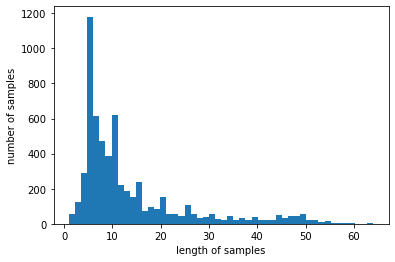

전체 샘플 중 길이가 55 이하인 샘플의 비율: 99.74987493746873
전체 샘플 중 길이가 55 이하인 샘플의 비율: 99.79989994997499
(5997, 55) (1999, 55)

DNN 모델 진행합니다.
Epoch 1/30
144/150 [===========================>..] - ETA: 0s - loss: 0.6805 - acc: 0.5552
Epoch 00001: val_acc improved from -inf to 0.56339, saving model to best_model.h5
150/150 [==============================] - 2s 14ms/step - loss: 0.6801 - acc: 0.5568 - val_loss: 0.6774 - val_acc: 0.5634
Epoch 2/30
150/150 [==============================] - ETA: 0s - loss: 0.6703 - acc: 0.5719
Epoch 00002: val_acc improved from 0.56339 to 0.56421, saving model to best_model.h5
150/150 [==============================] - 1s 9ms/step - loss: 0.6703 - acc: 0.5719 - val_loss: 0.6761 - val_acc: 0.5642
Epoch 3/30
144/150 [===========================>..] - ETA: 0s - loss: 0.6673 - acc: 0.5727
Epoch 00003: val_acc improved from 0.56421 to 0.56462, saving model to best_model.h5
150/150 [==============================] - 1s 9ms/step - loss: 0.6670 - acc: 0.5732 - val_loss: 0.6777 - 

Epoch 7/30
150/150 [==============================] - ETA: 0s - loss: 0.6209 - acc: 0.8276
Epoch 00007: val_acc did not improve from 0.79667
150/150 [==============================] - 15s 100ms/step - loss: 0.6209 - acc: 0.8276 - val_loss: 5.8023 - val_acc: 0.7208
Epoch 8/30
150/150 [==============================] - ETA: 0s - loss: 8831.7324 - acc: 0.6496
Epoch 00008: val_acc did not improve from 0.79667
150/150 [==============================] - 18s 121ms/step - loss: 8831.7324 - acc: 0.6496 - val_loss: 0.5880 - val_acc: 0.6692
Epoch 9/30
150/150 [==============================] - ETA: 0s - loss: 0.5404 - acc: 0.8040
Epoch 00009: val_acc did not improve from 0.79667
150/150 [==============================] - 15s 102ms/step - loss: 0.5404 - acc: 0.8040 - val_loss: 0.5680 - val_acc: 0.7000
Epoch 10/30
150/150 [==============================] - ETA: 0s - loss: 0.4268 - acc: 0.8418
Epoch 00010: val_acc did not improve from 0.79667
150/150 [==============================] - 18s 120ms/step

Epoch 18/30
150/150 [==============================] - ETA: 0s - loss: 0.3767 - acc: 0.8657
Epoch 00018: val_acc did not improve from 0.77583
150/150 [==============================] - 14s 93ms/step - loss: 0.3767 - acc: 0.8657 - val_loss: 14.5919 - val_acc: 0.7608
Epoch 19/30
150/150 [==============================] - ETA: 0s - loss: 0.4359 - acc: 0.8553
Epoch 00019: val_acc did not improve from 0.77583
150/150 [==============================] - 15s 100ms/step - loss: 0.4359 - acc: 0.8553 - val_loss: 14.5247 - val_acc: 0.7592
Epoch 20/30
150/150 [==============================] - ETA: 0s - loss: 0.3594 - acc: 0.8616-
Epoch 00020: val_acc did not improve from 0.77583
150/150 [==============================] - 14s 95ms/step - loss: 0.3594 - acc: 0.8616 - val_loss: 15.3589 - val_acc: 0.7525
Epoch 21/30
150/150 [==============================] - ETA: 0s - loss: 0.3408 - acc: 0.8683
Epoch 00021: val_acc did not improve from 0.77583
150/150 [==============================] - 13s 86ms/step -

147/150 [============================>.] - ETA: 0s - loss: 0.3564 - acc: 0.8593
Epoch 00002: val_acc improved from 0.79167 to 0.79583, saving model to best_model.h5
150/150 [==============================] - 2s 15ms/step - loss: 0.3556 - acc: 0.8597 - val_loss: 0.4637 - val_acc: 0.7958
Epoch 3/30
149/150 [============================>.] - ETA: 0s - loss: 0.2584 - acc: 0.9044
Epoch 00003: val_acc did not improve from 0.79583
150/150 [==============================] - 2s 16ms/step - loss: 0.2601 - acc: 0.9039 - val_loss: 0.5305 - val_acc: 0.7842
Epoch 4/30
149/150 [============================>.] - ETA: 0s - loss: 0.2017 - acc: 0.9295
Epoch 00004: val_acc did not improve from 0.79583
150/150 [==============================] - 5s 33ms/step - loss: 0.2025 - acc: 0.9291 - val_loss: 0.6131 - val_acc: 0.7742
Epoch 5/30
147/150 [============================>.] - ETA: 0s - loss: 0.1627 - acc: 0.9452
Epoch 00005: val_acc did not improve from 0.79583
150/150 [==============================] - 2s 

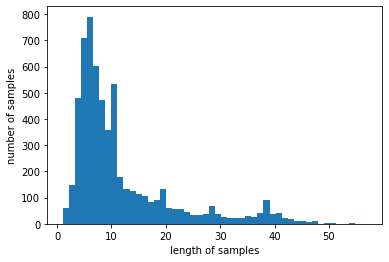

전체 샘플 중 길이가 55 이하인 샘플의 비율: 99.98332499583125
전체 샘플 중 길이가 55 이하인 샘플의 비율: 100.0
(5997, 55) (1999, 55)

DNN 모델 진행합니다.
Epoch 1/30
146/150 [============================>.] - ETA: 0s - loss: 0.6835 - acc: 0.5469
Epoch 00001: val_acc improved from -inf to 0.55476, saving model to best_model.h5
150/150 [==============================] - 1s 10ms/step - loss: 0.6832 - acc: 0.5485 - val_loss: 0.6778 - val_acc: 0.5548
Epoch 2/30
150/150 [==============================] - ETA: 0s - loss: 0.6723 - acc: 0.5626
Epoch 00002: val_acc improved from 0.55476 to 0.55495, saving model to best_model.h5
150/150 [==============================] - 1s 9ms/step - loss: 0.6723 - acc: 0.5626 - val_loss: 0.6780 - val_acc: 0.5550
Epoch 3/30
146/150 [============================>.] - ETA: 0s - loss: 0.6695 - acc: 0.5643
Epoch 00003: val_acc improved from 0.55495 to 0.55495, saving model to best_model.h5
150/150 [==============================] - 1s 9ms/step - loss: 0.6694 - acc: 0.5638 - val_loss: 0.6803 - val_acc: 0.5

Epoch 7/30
150/150 [==============================] - ETA: 0s - loss: 81.9634 - acc: 0.8061
Epoch 00007: val_acc did not improve from 0.80250
150/150 [==============================] - 17s 112ms/step - loss: 81.9634 - acc: 0.8061 - val_loss: 0.5809 - val_acc: 0.7608
Epoch 8/30
150/150 [==============================] - ETA: 0s - loss: 0.4402 - acc: 0.8582
Epoch 00008: val_acc did not improve from 0.80250
150/150 [==============================] - 19s 125ms/step - loss: 0.4402 - acc: 0.8582 - val_loss: 0.7181 - val_acc: 0.7942
Epoch 9/30
150/150 [==============================] - ETA: 0s - loss: 0.3815 - acc: 0.8741
Epoch 00009: val_acc did not improve from 0.80250
150/150 [==============================] - 18s 120ms/step - loss: 0.3815 - acc: 0.8741 - val_loss: 0.5892 - val_acc: 0.8017
Epoch 10/30
150/150 [==============================] - ETA: 0s - loss: 0.3129 - acc: 0.8822
Epoch 00010: val_acc did not improve from 0.80250
150/150 [==============================] - 18s 117ms/step - l

Epoch 8/30
150/150 [==============================] - ETA: 0s - loss: 1031.4158 - acc: 0.8695
Epoch 00008: val_acc did not improve from 0.78750
150/150 [==============================] - 29s 191ms/step - loss: 1031.4158 - acc: 0.8695 - val_loss: 43.0523 - val_acc: 0.7633
Epoch 9/30
150/150 [==============================] - ETA: 0s - loss: 2894.2861 - acc: 0.8747
Epoch 00009: val_acc did not improve from 0.78750
150/150 [==============================] - 28s 184ms/step - loss: 2894.2861 - acc: 0.8747 - val_loss: 72.4161 - val_acc: 0.7592
Epoch 10/30
150/150 [==============================] - ETA: 0s - loss: 183504.8750 - acc: 0.8624
Epoch 00010: val_acc did not improve from 0.78750
150/150 [==============================] - 27s 180ms/step - loss: 183504.8750 - acc: 0.8624 - val_loss: 2491.2185 - val_acc: 0.7175
Epoch 11/30
150/150 [==============================] - ETA: 0s - loss: 1259.1605 - acc: 0.8503
Epoch 00011: val_acc did not improve from 0.78750
150/150 [=======================

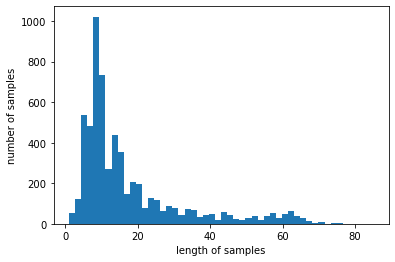

전체 샘플 중 길이가 55 이하인 샘플의 비율: 94.83074870768718
전체 샘플 중 길이가 55 이하인 샘플의 비율: 94.14707353676839
(5997, 55) (1999, 55)

DNN 모델 진행합니다.
Epoch 1/30
146/150 [============================>.] - ETA: 0s - loss: 0.6777 - acc: 0.5745
Epoch 00001: val_acc improved from -inf to 0.57773, saving model to best_model.h5
150/150 [==============================] - 2s 14ms/step - loss: 0.6773 - acc: 0.5753 - val_loss: 0.6734 - val_acc: 0.5777
Epoch 2/30
145/150 [============================>.] - ETA: 0s - loss: 0.6658 - acc: 0.5873
Epoch 00002: val_acc improved from 0.57773 to 0.57802, saving model to best_model.h5
150/150 [==============================] - 1s 9ms/step - loss: 0.6663 - acc: 0.5859 - val_loss: 0.6733 - val_acc: 0.5780
Epoch 3/30
146/150 [============================>.] - ETA: 0s - loss: 0.6637 - acc: 0.5863
Epoch 00003: val_acc did not improve from 0.57802
150/150 [==============================] - 1s 8ms/step - loss: 0.6636 - acc: 0.5877 - val_loss: 0.6735 - val_acc: 0.5774
Epoch 4/30
147/150 

Epoch 7/30
150/150 [==============================] - ETA: 0s - loss: 0.2587 - acc: 0.8999
Epoch 00007: val_acc did not improve from 0.77083
150/150 [==============================] - 18s 122ms/step - loss: 0.2587 - acc: 0.8999 - val_loss: 0.5990 - val_acc: 0.7667
Epoch 8/30
150/150 [==============================] - ETA: 0s - loss: 54210.0430 - acc: 0.8449
Epoch 00008: val_acc did not improve from 0.77083
150/150 [==============================] - 14s 96ms/step - loss: 54210.0430 - acc: 0.8449 - val_loss: 51.0623 - val_acc: 0.6383
Epoch 9/30
150/150 [==============================] - ETA: 0s - loss: 6.6590 - acc: 0.7006
Epoch 00009: val_acc did not improve from 0.77083
150/150 [==============================] - 16s 109ms/step - loss: 6.6590 - acc: 0.7006 - val_loss: 2.3925 - val_acc: 0.6592
Epoch 10/30
150/150 [==============================] - ETA: 0s - loss: 1.6679 - acc: 0.7044
Epoch 00010: val_acc did not improve from 0.77083
150/150 [==============================] - 16s 104ms/st

150/150 [==============================] - ETA: 0s - loss: 2.0608 - acc: 0.6965
Epoch 00002: val_acc improved from 0.67000 to 0.71083, saving model to best_model.h5
150/150 [==============================] - 29s 190ms/step - loss: 2.0608 - acc: 0.6965 - val_loss: 0.6316 - val_acc: 0.7108
Epoch 3/30
150/150 [==============================] - ETA: 0s - loss: 10872.6367 - acc: 0.5741
Epoch 00003: val_acc did not improve from 0.71083
150/150 [==============================] - 26s 172ms/step - loss: 10872.6367 - acc: 0.5741 - val_loss: 0.7096 - val_acc: 0.4925
Epoch 4/30
150/150 [==============================] - ETA: 0s - loss: 0.7216 - acc: 0.5087
Epoch 00004: val_acc did not improve from 0.71083
150/150 [==============================] - 29s 190ms/step - loss: 0.7216 - acc: 0.5087 - val_loss: 0.7423 - val_acc: 0.4925
Epoch 5/30
150/150 [==============================] - ETA: 0s - loss: 1.0760 - acc: 0.5266
Epoch 00005: val_acc improved from 0.71083 to 0.74917, saving model to best_model.

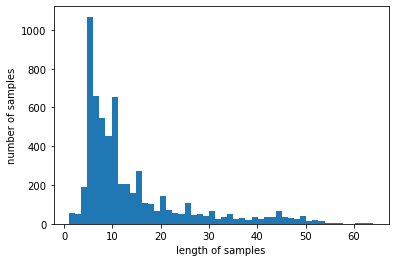

전체 샘플 중 길이가 55 이하인 샘플의 비율: 99.78322494580624
전체 샘플 중 길이가 55 이하인 샘플의 비율: 99.74987493746873
(5997, 55) (1999, 55)

DNN 모델 진행합니다.
Epoch 1/30
149/150 [============================>.] - ETA: 0s - loss: 0.6802 - acc: 0.5615
Epoch 00001: val_acc improved from -inf to 0.56427, saving model to best_model.h5
150/150 [==============================] - 2s 15ms/step - loss: 0.6802 - acc: 0.5617 - val_loss: 0.6753 - val_acc: 0.5643
Epoch 2/30
148/150 [============================>.] - ETA: 0s - loss: 0.6697 - acc: 0.5724
Epoch 00002: val_acc improved from 0.56427 to 0.56429, saving model to best_model.h5
150/150 [==============================] - 1s 10ms/step - loss: 0.6697 - acc: 0.5723 - val_loss: 0.6752 - val_acc: 0.5643
Epoch 3/30
144/150 [===========================>..] - ETA: 0s - loss: 0.6667 - acc: 0.5744
Epoch 00003: val_acc improved from 0.56429 to 0.56429, saving model to best_model.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.6671 - acc: 0.5737 - val_loss: 0.6765 

Epoch 7/30
150/150 [==============================] - ETA: 0s - loss: 0.3454 - acc: 0.8612
Epoch 00007: val_acc did not improve from 0.79833
150/150 [==============================] - 17s 115ms/step - loss: 0.3454 - acc: 0.8612 - val_loss: 0.6606 - val_acc: 0.7658
Epoch 8/30
150/150 [==============================] - ETA: 0s - loss: 0.3116 - acc: 0.8753
Epoch 00008: val_acc did not improve from 0.79833
150/150 [==============================] - 15s 102ms/step - loss: 0.3116 - acc: 0.8753 - val_loss: 0.6798 - val_acc: 0.7583
Epoch 9/30
150/150 [==============================] - ETA: 0s - loss: 0.2913 - acc: 0.8826
Epoch 00009: val_acc did not improve from 0.79833
150/150 [==============================] - 18s 120ms/step - loss: 0.2913 - acc: 0.8826 - val_loss: 0.6923 - val_acc: 0.7567
Epoch 10/30
150/150 [==============================] - ETA: 0s - loss: 0.2676 - acc: 0.8935
Epoch 00010: val_acc did not improve from 0.79833
150/150 [==============================] - 16s 109ms/step - los

Epoch 8/30
150/150 [==============================] - ETA: 0s - loss: 95228.9141 - acc: 0.5672
Epoch 00008: val_acc did not improve from 0.72583
150/150 [==============================] - 26s 177ms/step - loss: 95228.9141 - acc: 0.5672 - val_loss: 18020.2207 - val_acc: 0.5892
Epoch 9/30
150/150 [==============================] - ETA: 0s - loss: 120725.7969 - acc: 0.5428
Epoch 00009: val_acc did not improve from 0.72583
150/150 [==============================] - 29s 195ms/step - loss: 120725.7969 - acc: 0.5428 - val_loss: 229134.0000 - val_acc: 0.5850
Epoch 10/30
150/150 [==============================] - ETA: 0s - loss: 141242.7812 - acc: 0.5835
Epoch 00010: val_acc did not improve from 0.72583
150/150 [==============================] - 30s 199ms/step - loss: 141242.7812 - acc: 0.5835 - val_loss: 70908.2578 - val_acc: 0.6167
Epoch 11/30
150/150 [==============================] - ETA: 0s - loss: 2568281.0000 - acc: 0.4936
Epoch 00011: val_acc did not improve from 0.72583
150/150 [======

In [109]:
test_result = []
token_name = ['token_okt1', 'token_okt2', 'token_mecab1', 'token_mecab2']
for token in token_name:
    print(token , "방식 진행합니다.\n")
    X_train, y_train, X_test, y_test, vocab_size = convert_input(token,2)
    padding_len(55, X_train)
    padding_len(55, X_test)
    X_train, X_test,max_len = padding(55)
    
    if token =='token_okt1':
        token = "okt"
    elif token =='token_okt2':
        token = "okt_조사제거"
    elif token =='token_mecab1':
        token = "mecab"
    elif token =='token_mecab2':
        token = "mecab_조사제거"
    
    print("\nDNN 모델 진행합니다.")
    DNN()
    print("\nLSTM 모델 진행합니다.")
    lstm()
    print("\nLSTM_2layer 모델 진행합니다.")
    lstm_2_layer()
    print("\nBi-LSTM 모델 진행합니다.")
    bidirectional_lstm()
    print("\nBi-LSTM 2층 모델 진행합니다.")
    bidirectional_lstm_2()
    print("\1D-CNN 모델 진행합니다.")
    cnn_1D()

In [110]:
test_df = pd.DataFrame(test_result,columns=['형태소 분석','모델명','test 정확도'])
test_df

,형태소 분석,모델명,test 정확도
0,okt,DNN,0.546701
1,okt,LSTM,0.792896
2,okt,LSTM_2layer,0.789895
3,okt,Bi-LSTM,0.770385
4,okt,Bi-LSTM-2,0.510255
5,okt,1D-CNN,0.799400
6,okt_조사제거,DNN,0.537605
7,okt_조사제거,LSTM,0.798899
8,okt_조사제거,LSTM_2layer,0.781891
9,okt_조사제거,Bi-LSTM,0.775388
